# QUIZ 5 - Object Recognition: BoF vs ConvNetsTarefa

## Grupo: Luiz Gontijo, Marcos Vinicius, Matheus Pimenta

In [2]:
import numpy as np
import pickle
import cv2 as cv
from matplotlib import pyplot as plt
import scipy.misc as smp

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
batch1 = unpickle("./cifar-10-python/cifar-10-batches-py/data_batch_1")
for key in batch1:
    print(key)



b'batch_label'
b'labels'
b'data'
b'filenames'


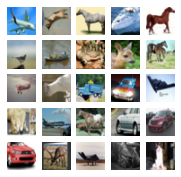

In [20]:
X = batch1[b"data"] 
Y = batch1[b'labels']
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
Y = np.array(Y)

#Visualizing CIFAR 10
fig, axes1 = plt.subplots(5,5,figsize=(3,3))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])
